In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

tf.config.list_physical_devices('GPU')

Duplicate key in file PosixPath('/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc'), line 401 ('axes.unicode_minus: True  # use Unicode for the minus symbol rather than hyphen.  See')


[]

In [2]:
import urllib3
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
'cifar10',
split=['train', 'test'],
shuffle_files=True,
with_info=True,
)

In [3]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [4]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [5]:
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32)/255., label

In [6]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    
    ds = ds.map(normalize_on_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds=ds.repeat()
        ds=ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.expremental.AUTOTUNE)
    return ds  

In [7]:
ds_info.features["label"].num_classes

10

In [8]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

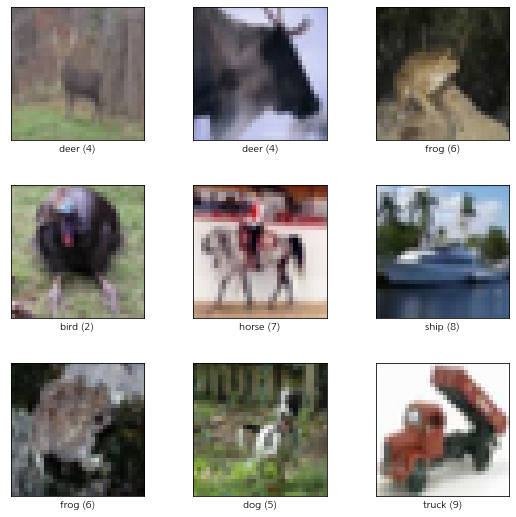

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

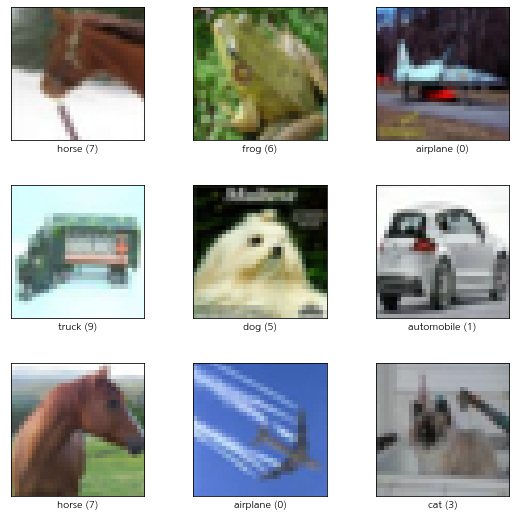

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

In [53]:
def build_resnet_block(input_layer ,num_cnn=2,stage_num=2, channel=64, is_50=False, is_plain=True):
    
    x = input_layer
    short = x
  
    if not is_50:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                x = keras.layers.Conv2D(filters=channel, 
                                        kernel_size=(3, 3), 
                                        padding='same',
                                        strides=stride,
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)

                if is_plain == False:
                    short = keras.layers.Conv2D(filters=channel,
                                                kernel_size=(1, 1),
                                                strides=stride,
                                                padding='same',
                                                name=f'stage{stage_num}_{cnn_num+1}_short',
                                                )(short)
                    short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(short)
                    x = keras.layers.Add()([x, short])
                
                x = keras.layers.Activation('relu')(x)

                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                        )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn2')(x)

                if is_plain == False:
                    x = keras.layers.Add()([x, short])

                x = keras.layers.Activation('relu')(x)

                short = x

    else:
        for cnn_num in range(num_cnn):
            if cnn_num == 0:
                
                if stage_num == 2:
                    stride = 1
                else:
                    stride = 2
                    
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        strides = stride,
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                if is_plain == False:
                    short = keras.layers.Conv2D(filters=channel*4,
                                                kernel_size=(1, 1),
                                                strides=stride,
                                                padding='same',
                                                name=f'stage{stage_num}_{cnn_num+1}_short',
                                                )(short)
                    short = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn4')(short)
                    x = keras.layers.Add()([x, short])
                x = keras.layers.Activation('relu')(x)
                
                short = x
            else:
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv1',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn1')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel,
                                        kernel_size=(3, 3),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv2',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stae{stage_num}_{cnn_num+1}_bn2')(x)
                x = keras.layers.Activation('relu')(x)
                x = keras.layers.Conv2D(filters=channel*4,
                                        kernel_size=(1, 1),
                                        padding='same',
                                        name=f'stage{stage_num}_{cnn_num+1}_conv3',
                                       )(x)
                x = keras.layers.BatchNormalization(name=f'stage{stage_num}_{cnn_num+1}_bn3')(x)
                
                if is_plain == False:
                    x = keras.layers.Add()([x, short])
                    
                x = keras.layers.Activation('relu')(x)
                
                short = x

                    
    return x
    

In [54]:
def build_resnet(input_shape=(32, 32, 3), is_50=False, is_plain=True):
    
    num_cnn_ls = [3, 4, 6, 3]
    channel_ls = [64, 128, 256, 512]
    num_classes = 10
    
    
        
    input_layer = keras.layers.Input(shape=input_shape)

    x = input_layer
    x = keras.layers.Conv2D(filters = 64,
                            kernel_size=(7, 7),
                            strides=2,
                            kernel_initializer='he_normal',
                            padding='same',
                            name=f'conv2d_0',
                            )(x)

    x = keras.layers.BatchNormalization(name=f'batch_normalization_0')(x)
    x = keras.layers.Activation('relu', name=f'activation_0')(x)
    x = keras.layers.MaxPool2D(pool_size=(3,3), strides=2, padding='same', name=f'stage2_0_maxpooling')(x)
    
    output = x 
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_ls, channel_ls)):
        output = build_resnet_block(output,
                                    num_cnn=num_cnn,
                                    stage_num = i+2,
                                    channel=channel,
                                    is_50 = is_50,
                                    is_plain = is_plain,
                                    )

    output = keras.layers.AveragePooling2D(pool_size = 1,
                                           padding='same',
                                           name='avg_pool')(output)
    output = keras.layers.Flatten(name='flatten_6')(output)
    output = keras.layers.Dense(num_classes, activation='softmax',name='predictions')(output)

    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [55]:
resnet_34 = build_resnet(is_plain=False)
resnet_34_plain = build_resnet(is_plain=True)
resnet_50 = build_resnet(is_50=True, is_plain=False)
resnet_50_plain = build_resnet(is_50=True, is_plain=True)

In [56]:
resnet_34.summary()

Model: "functional_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_0 (BatchNor (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 16, 16, 64)   0           batch_normalization_0[0][0]      
______________________________________________________________________________________

In [57]:
resnet_34_plain.summary()

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_0 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_0 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 64)          36928     
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 8, 8, 64)        

In [58]:
resnet_50.summary()

Model: "functional_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_0 (Conv2D)               (None, 16, 16, 64)   9472        input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_0 (BatchNor (None, 16, 16, 64)   256         conv2d_0[0][0]                   
__________________________________________________________________________________________________
activation_0 (Activation)       (None, 16, 16, 64)   0           batch_normalization_0[0][0]      
______________________________________________________________________________________

In [59]:
resnet_50_plain.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_0 (Conv2D)            (None, 16, 16, 64)        9472      
_________________________________________________________________
batch_normalization_0 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
activation_0 (Activation)    (None, 16, 16, 64)        0         
_________________________________________________________________
stage2_0_maxpooling (MaxPool (None, 8, 8, 64)          0         
_________________________________________________________________
stage2_1_conv1 (Conv2D)      (None, 8, 8, 64)          4160      
_________________________________________________________________
stage2_1_bn1 (BatchNormaliza (None, 8, 8, 64)        